<a href="https://colab.research.google.com/github/shinyabe/-/blob/main/%E5%8D%92%E8%AB%96%E3%82%B7%E3%83%9F%E3%83%A5%E3%83%AC%E3%83%BC%E3%82%B7%E3%83%A7%E3%83%B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
from __future__ import annotations
from dataclasses import dataclass
import math
import random
from typing import Dict, Tuple, List

# 乱数を固定
random.seed(42)

# ------------------------------
# 問題サイズ・集合の定義
# ------------------------------
T = 30                             # 計算する日数
G_LIST = ['L', 'S']                # 商品カテゴリ：L=根菜（長持ち）, S=葉物（短命）
S_LIST = [1, 2, 3]                 # 鮮度状態：1=良、2=やや劣化、3=販売不可(廃棄)
N_LIST = ['W', 'R']                # 節点：W=卸、R=小売

# ------------------------------
# 価格・費用・需要などのパラメータ
# ------------------------------
P_LIST = {'L': 180.0, 'S': 180.0}  # 小売定価
DELTA  = {'L': 0.8,   'S': 0.7}    # 割引率（割引価格＝DELTA[g]*P_LIST[g]）

P_W2R  = {'L': 120.0, 'S': 120.0}  # 卸→小売の取引価格
C_BUY  = {'L': 90.0,  'S': 90.0}   # 卸の仕入単価

# 保管コスト（節点n×カテゴリg×状態sごとに設定）
C_STOR = {
    ('W','L',1):1.0, ('W','L',2):1.0, ('W','L',3):1.0,
    ('W','S',1):1.2, ('W','S',2):1.2, ('W','S',3):1.2,
    ('R','L',1):1.5, ('R','L',2):1.5, ('R','L',3):1.5,
    ('R','S',1):2.0, ('R','S',2):2.0, ('R','S',3):2.0,
}

C_SHIP = {'L': 8.0, 'S': 8.0}      # 配送費（円/個）
C_DISC = {'L': 50.0, 'S': 50.0}    # 割引運用の固定費（ONの日だけ課す）

# 日別の需要上限（定価・割引）。実務では価格連動の需要関数に置き換え可
D_FULL = {('L',t): 50.0 for t in range(1,T+1)}
D_FULL.update({('S',t): 60.0 for t in range(1,T+1)})
D_DISC = {('L',t): 30.0 for t in range(1,T+1)}
D_DISC.update({('S',t): 50.0 for t in range(1,T+1)})

# 初期在庫：基本ゼロ。小売にだけS(葉物)の状態1を少し持たせる例
I_INIT = { (n,g,s): 0.0 for n in N_LIST for g in G_LIST for s in S_LIST }
I_INIT[('R','S',1)] = 10.0

# 保管容量（ここでは使っていないが、容量制約を入れる拡張が容易）
C_STOR_CAP = {'W': 1000.0, 'R': 400.0}

# CO2排出原単位（保存強度θ=0/1で異なる値）
E_STOR0 = {'W': 0.002, 'R': 0.003}  # 通常保存
E_STOR1 = {'W': 0.004, 'R': 0.006}  # 高品質保存（電力↑）
E_SHIP  = {'L': 0.01,  'S': 0.01}   # 配送（kgCO2/個）
# 配送1便あたりのCO2排出量（kgCO2/便）
E_TRIP = 2.5        # 例：2.5 kgCO2/便（トラック種別・距離で調整）

# 1便で運べる最大個数（車両容量）。配送回数=ceil(当日出荷総数 / CAP_TRUCK)
CAP_TRUCK = 200     # 例：200 個/便（適宜変更）


# ------------------------------
# 鮮度遷移確率（θ=0のP0, θ=1のP1）
# ・各(s_from)で(s_to)への和が1になるよう設定
# ・根菜は劣化が遅く、葉物は速い
# ------------------------------
P0 = {}
P1 = {}
for n in N_LIST:
    # 根菜 L
    P0[(n,'L',1,1)] = 0.85; P0[(n,'L',1,2)] = 0.15; P0[(n,'L',1,3)] = 0.0  #通常保存
    P0[(n,'L',2,1)] = 0.0;  P0[(n,'L',2,2)] = 0.70; P0[(n,'L',2,3)] = 0.30
    P0[(n,'L',3,1)] = 0.0;  P0[(n,'L',3,2)] = 0.0;  P0[(n,'L',3,3)] = 1.00
    P1[(n,'L',1,1)] = 0.92; P1[(n,'L',1,2)] = 0.08; P1[(n,'L',1,3)] = 0.0  #冷蔵保存
    P1[(n,'L',2,1)] = 0.0;  P1[(n,'L',2,2)] = 0.80; P1[(n,'L',2,3)] = 0.20
    P1[(n,'L',3,1)] = 0.0;  P1[(n,'L',3,2)] = 0.0;  P1[(n,'L',3,3)] = 1.00
    # 葉物 S
    P0[(n,'S',1,1)] = 0.70; P0[(n,'S',1,2)] = 0.30; P0[(n,'S',1,3)] = 0.0  #通常保存
    P0[(n,'S',2,1)] = 0.0;  P0[(n,'S',2,2)] = 0.55; P0[(n,'S',2,3)] = 0.45
    P0[(n,'S',3,1)] = 0.0;  P0[(n,'S',3,2)] = 0.0;  P0[(n,'S',3,3)] = 1.00
    P1[(n,'S',1,1)] = 0.80; P1[(n,'S',1,2)] = 0.20; P1[(n,'S',1,3)] = 0.0  #冷蔵保存
    P1[(n,'S',2,1)] = 0.0;  P1[(n,'S',2,2)] = 0.65; P1[(n,'S',2,3)] = 0.35
    P1[(n,'S',3,1)] = 0.0;  P1[(n,'S',3,2)] = 0.0;  P1[(n,'S',3,3)] = 1.00

# ------------------------------
# 目的関数の重み（利潤を最大化し、CO2・廃棄は罰則で最小化）
# ------------------------------
LAMBDA_W = 1.0
LAMBDA_R = 1.0
ALPHA_CO2 = 50.0   # 1 kgCO2 あたりのペナルティ（円相当）
BETA_WASTE = 5.0   # 1 個廃棄あたりのペナルティ

# ------------------------------
# 探索する「政策」の定義（意思決定ルール）
# ------------------------------
@dataclass
class Policy:
    buy_L: float       # 根菜の日次仕入量（定数方針）
    buy_S: float       # 葉物の日次仕入量（定数方針）
    th_theta_W: float  # 卸の高品質保存ONにする在庫総量の閾値
    th_theta_R: float  # 小売の高品質保存ONにする在庫総量の閾値
    target_R_L: float  # 小売の根菜目標在庫（状態1+2）
    target_R_S: float  # 小売の葉物目標在庫（状態1+2）
    th_disc_L: float   # 根菜：状態2在庫がこの閾値以上で割引ON
    th_disc_S: float   # 葉物：状態2在庫がこの閾値以上で割引ON

def random_policy() -> Policy:
    """ ランダムに初期政策を生成（ランダム探索の初期点） """
    return Policy(
        buy_L=random.uniform(20, 80),
        buy_S=random.uniform(20, 80),
        th_theta_W=random.uniform(80, 200),
        th_theta_R=random.uniform(40, 120),
        target_R_L=random.uniform(40, 120),
        target_R_S=random.uniform(40, 120),
        th_disc_L=random.uniform(10, 80),
        th_disc_S=random.uniform(10, 80),
    )

def neighbor_policy(p: Policy, scale: float=0.15) -> Policy:
    """ 既存政策の近傍（少しだけ値を揺らす）を作る：局所探索用 """
    q = Policy(**p.__dict__)
    def jiggle(x, lo, hi):
        span = (hi - lo) * scale
        return max(lo, min(hi, x + random.uniform(-span, span)))
    q.buy_L = jiggle(p.buy_L,  0, 150)
    q.buy_S = jiggle(p.buy_S,  0, 150)
    q.th_theta_W = jiggle(p.th_theta_W,  0, 300)
    q.th_theta_R = jiggle(p.th_theta_R,  0, 300)
    q.target_R_L = jiggle(p.target_R_L, 0, 200)
    q.target_R_S = jiggle(p.target_R_S, 0, 200)
    q.th_disc_L  = jiggle(p.th_disc_L,  0, 200)
    q.th_disc_S  = jiggle(p.th_disc_S,  0, 200)
    return q

# ------------------------------
# 劣化遷移の計算（保存強度θで線形補間）
# ------------------------------
def peff(n,g,sf,st,theta):
    return (1-theta)*P0[(n,g,sf,st)] + theta*P1[(n,g,sf,st)]

def inv_next(n,g,inv,arrival,theta):
    """
    在庫ベクトル inv(状態→個数) と 当日到着 arrival を合計し、
    1日分の鮮度遷移で s_from→s_to へ振り分けた在庫ベクトルを返す。
    """
    out = {1:0.0,2:0.0,3:0.0}
    for sf in S_LIST:
        total_sf = inv.get(sf,0.0) + arrival.get(sf,0.0)
        if total_sf<=0:
            continue
        for st in S_LIST:
            out[st] += peff(n,g,sf,st,theta)*total_sf
    return out

# ------------------------------
# シミュレーション（与えた政策でT日回す）
# ------------------------------
@dataclass
class SimResult:
    objective: float  # 目的値（利潤合計 − 罰則）
    profit_W: float   # 卸利潤合計
    profit_R: float   # 小売利潤合計
    co2: float        # CO2排出量累計
    waste: float      # 廃棄個数累計
    history: List[dict]  # 必要なら日別ログを入れる

def simulate(policy:Policy)->SimResult:
    # 在庫の初期化（辞書：カテゴリ→{状態→数量}）
    I_W = { g:{1:0.0,2:0.0,3:0.0} for g in G_LIST }
    I_R = { g:{1:0.0,2:0.0,3:0.0} for g in G_LIST }
    for (n,g,s),v in I_INIT.items():
        if n=='W': I_W[g][s]=v
        else:      I_R[g][s]=v

    profit_W=profit_R=co2=waste_total=0.0
    hist=[]

    # --- 日次ループ ---
    for t in range(1,T+1):
        # 1) 仕入れ量（定数方針）と、在庫総量による保存強度ON/OFF
        x_buy={'L':policy.buy_L,'S':policy.buy_S}
        theta_W=1 if sum(I_W[g][s] for g in G_LIST for s in S_LIST)>=policy.th_theta_W else 0
        theta_R=1 if sum(I_R[g][s] for g in G_LIST for s in S_LIST)>=policy.th_theta_R else 0

        # 2) 卸→小売の出荷（小売目標在庫まで補充：s=1優先、次にs=2）
        x_ship={(g,s):0.0 for g in G_LIST for s in S_LIST}
        target_R={'L':policy.target_R_L,'S':policy.target_R_S}
        for g in G_LIST:
            need=max(0.0,target_R[g]-(I_R[g][1]+I_R[g][2]))
            take1=min(I_W[g][1]+x_buy[g],need)              # s=1 在庫＋当日入荷から優先
            x_ship[(g,1)]=take1; need-=take1
            take2=min(I_W[g][2],max(0.0,need))              # 足りなければ s=2 から
            x_ship[(g,2)]=take2; need-=take2

        # 3) 卸在庫の更新（出荷控除→到着加算→劣化遷移）。状態3は即日廃棄
        I_W_next={ g:{1:0.0,2:0.0,3:0.0} for g in G_LIST }
        waste_W_today=0.0
        for g in G_LIST:
            arrival_W={1:x_buy[g],2:0.0,3:0.0}             # 仕入は状態1として入庫
            avail_after={                                   # 出荷後の残量
                1:max(0,I_W[g][1]-x_ship[(g,1)]),
                2:max(0,I_W[g][2]-x_ship[(g,2)]),
                3:I_W[g][3]
            }
            I_W_next[g]=inv_next('W',g,avail_after,arrival_W,theta_W)
            waste_W_today+=I_W_next[g][3]                  # 状態3は廃棄として数える
            I_W_next[g][3]=0.0
        I_W=I_W_next

        # 4) 小売：到着反映→販売→劣化遷移。割引は状態2在庫が閾値超でON
        I_R_after={ g:{
            1:I_R[g][1]+x_ship[(g,1)],
            2:I_R[g][2]+x_ship[(g,2)],
            3:I_R[g][3]
        } for g in G_LIST }

        z_disc={
            'L':1 if I_R_after['L'][2]>=policy.th_disc_L else 0,
            'S':1 if I_R_after['S'][2]>=policy.th_disc_S else 0
        }

        # 定価販売→不足分をs=2で補う→（割引ONなら）割引販売
        x_sell_full={(g,s):0.0 for g in G_LIST for s in [1,2]}
        x_sell_disc={(g,2):0.0 for g in G_LIST}
        for g in G_LIST:
            demand_full=D_FULL[(g,t)]
            sell1=min(I_R_after[g][1],demand_full)         # まずs=1を定価で販売
            x_sell_full[(g,1)]=sell1; demand_full-=sell1
            sell2_full=min(I_R_after[g][2],max(0,demand_full))  # それでも足りなければs=2を定価で
            x_sell_full[(g,2)]=sell2_full
            I_R_after[g][1]-=sell1; I_R_after[g][2]-=sell2_full

            if z_disc[g]==1:                                # 割引ONの時だけ割引需要を受ける
                demand_disc=D_DISC[(g,t)]
                sell2_disc=min(I_R_after[g][2],demand_disc)
                x_sell_disc[(g,2)]=sell2_disc
                I_R_after[g][2]-=sell2_disc

        # 販売後の在庫を劣化遷移。状態3は廃棄
        I_R_next={ g:{1:0.0,2:0.0,3:0.0} for g in G_LIST }
        waste_R_today=0.0
        for g in G_LIST:
            I_R_next[g]=inv_next('R',g,I_R_after[g],{1:0.0,2:0.0,3:0.0},theta_R)
            waste_R_today+=I_R_next[g][3]
            I_R_next[g][3]=0.0
        I_R=I_R_next

        # 5) 利潤（卸・小売）と CO2、廃棄の集計
        ship_qty_g={g:x_ship[(g,1)]+x_ship[(g,2)] for g in G_LIST}

        # 卸：売上 − 仕入 − 配送費 − 保管費
        rev_W   = sum(P_W2R[g]*ship_qty_g[g] for g in G_LIST)
        buy_W   = sum(C_BUY[g]*x_buy[g]      for g in G_LIST)
        ship_c  = sum(C_SHIP[g]*ship_qty_g[g]for g in G_LIST)
        stor_W  = sum(C_STOR[('W',g,s)]*I_W[g][s] for g in G_LIST for s in S_LIST)
        profit_W+=(rev_W-buy_W-ship_c-stor_W)

        # 小売：売上(定価＋割引) − 仕入 − 保管費 − 割引固定費
        rev_R_full = sum(P_LIST[g]*x_sell_full[(g,1)] for g in G_LIST) \
                   + sum(P_LIST[g]*x_sell_full[(g,2)] for g in G_LIST)
        rev_R_disc = sum(DELTA[g]*P_LIST[g]*x_sell_disc[(g,2)] for g in G_LIST)
        cost_pur   = sum(P_W2R[g]*ship_qty_g[g] for g in G_LIST)
        stor_R     = sum(C_STOR[('R',g,s)]*I_R[g][s] for g in G_LIST for s in S_LIST)
        disc_fix   = sum(C_DISC[g]*z_disc[g] for g in G_LIST)
        profit_R  += (rev_R_full+rev_R_disc) - cost_pur - stor_R - disc_fix

        # CO2（配送＋保管）。※保管はθに応じた原単位×在庫量の合計
        # 出荷総数から配送回数を計算（容量で割って切り上げ）
        total_ship = sum(ship_qty_g.values())
        trips = math.ceil(total_ship / CAP_TRUCK) if total_ship > 0 else 0

        # 配送CO2 = (配送1回あたり排出 × 配送回数) + (商品1個あたり排出 × 出荷数)
        co2_ship = E_TRIP * trips + sum(E_SHIP[g] * ship_qty_g[g] for g in G_LIST)

        co2_stor = (
            ((1-theta_W)*E_STOR0['W']+theta_W*E_STOR1['W']) * sum(I_W[g][s] for g in G_LIST for s in S_LIST)
          + ((1-theta_R)*E_STOR0['R']+theta_R*E_STOR1['R']) * sum(I_R[g][s] for g in G_LIST for s in S_LIST)
        )
        co2 += (co2_ship + co2_stor)

        # 廃棄（卸＋小売のその日の状態3）を加算
        waste_total += (waste_W_today + waste_R_today)

    # 6) 目的関数：利潤合計 − (CO2ペナルティ＋廃棄ペナルティ)
    obj = LAMBDA_W*profit_W + LAMBDA_R*profit_R - ALPHA_CO2*co2 - BETA_WASTE*waste_total
    return SimResult(obj,profit_W,profit_R,co2,waste_total,[])

# ------------------------------
# ランダム探索 + 近傍探索
# ------------------------------
def run_random_search(N_INIT:int=50,N_NEIGH:int=20)->Tuple[Policy,SimResult]:
    """
    1) ランダムに N_INIT 個の政策を作って一番良いものを選ぶ
    2) その政策の近傍を N_NEIGH 回試して、さらに良いものがあれば更新
    """
    best_p=None; best_r=None
    for _ in range(N_INIT):
        p=random_policy(); r=simulate(p)
        if (best_r is None) or (r.objective>best_r.objective):
            best_p,best_r=p,r
    for _ in range(N_NEIGH):
        q=neighbor_policy(best_p,0.2); rq=simulate(q)
        if rq.objective>best_r.objective:
            best_p,best_r=q,rq
    return best_p,best_r

# ------------------------------
# 実行部
# ------------------------------
if __name__=='__main__':
    best_policy,best_result=run_random_search(80,60)
    print('=== 最良政策 ==='); print(best_policy)
    print('\n=== 成績 ===')
    print(f'目的値:{best_result.objective:.2f}（円）')
    print(f'卸利潤:{best_result.profit_W:.2f}（円）')
    print(f'小売利潤:{best_result.profit_R:.2f}（円）')
    print(f'CO2:{best_result.co2:.3f}（kg）')
    print(f'廃棄:{best_result.waste:.2f}（個）')


=== 最良政策 ===
Policy(buy_L=26.86206275335957, buy_S=32.32971569403281, th_theta_W=119.77945310621415, th_theta_R=0, target_R_L=96.90172446460608, target_R_S=91.8790482916627, th_disc_L=78.67759816295026, th_disc_S=10.526857954151662)

=== 成績 ===
目的値:402753.54（円）
卸利潤:229351.74（円）
小売利潤:179788.85（円）
CO2:115.982（kg）
廃棄:117.59（個）


In [24]:
# 日本語フォント設定（Colabなどで文字化け防止）
import matplotlib.pyplot as plt
from matplotlib import font_manager

# IPAexゴシックをインストール（Google Colab など Linux 環境用）
!apt-get -y install fonts-ipafont-gothic > /dev/null

# フォントパスを設定
plt.rcParams['font.family'] = 'IPAGothic'   # または 'IPAexGothic'

# マイナス記号が文字化けしないように
plt.rcParams['axes.unicode_minus'] = False


/tmp/ipython-input-2536451414.py:38: UserWarning: Glyph 26681 (\N{CJK UNIFIED IDEOGRAPH-6839}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2536451414.py:38: UserWarning: Glyph 33756 (\N{CJK UNIFIED IDEOGRAPH-83DC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2536451414.py:38: UserWarning: Glyph 20181 (\N{CJK UNIFIED IDEOGRAPH-4ED5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2536451414.py:38: UserWarning: Glyph 20837 (\N{CJK UNIFIED IDEOGRAPH-5165}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2536451414.py:38: UserWarning: Glyph 33865 (\N{CJK UNIFIED IDEOGRAPH-8449}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2536451414.py:38: UserWarning: Glyph 29289 (\N{CJK UNIFIED IDEOGRAPH-7269}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2536451414.py:38: UserWarning: Glyph 21368 (\N{CJK UNIFIED IDEOGRAPH-5378}) missi

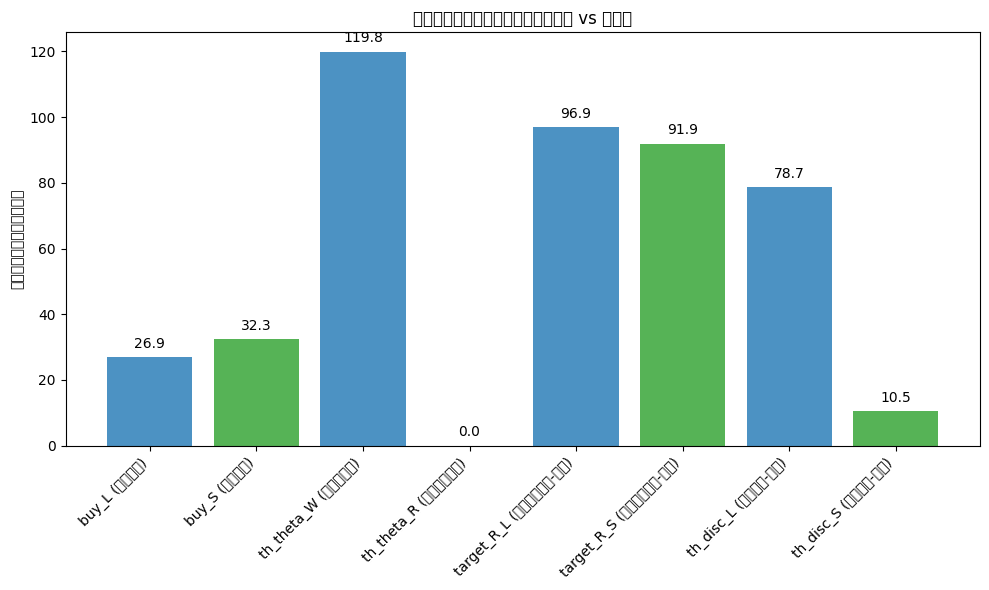

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def plot_best_policy(policy: Policy):
    """
    最良政策のパラメータを棒グラフで可視化
    根菜(L)と葉物(S)で色分けして比較
    """
    # 各パラメータのラベルと値を整理
    labels = [
        'buy_L (根菜仕入)', 'buy_S (葉物仕入)',
        'th_theta_W (卸保存閾値)', 'th_theta_R (小売保存閾値)',
        'target_R_L (小売在庫目標-根菜)', 'target_R_S (小売在庫目標-葉物)',
        'th_disc_L (割引閾値-根菜)', 'th_disc_S (割引閾値-葉物)'
    ]
    values = [
        policy.buy_L, policy.buy_S,
        policy.th_theta_W, policy.th_theta_R,
        policy.target_R_L, policy.target_R_S,
        policy.th_disc_L, policy.th_disc_S
    ]

    # 棒グラフを描画
    colors = ['#1f77b4', '#2ca02c'] * 4  # LとSを交互に色分け
    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, values, color=colors, alpha=0.8)

    # グラフの装飾
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('値（単位：個または閾値）')
    plt.title('最良政策パラメータの可視化（根菜 vs 葉物）')

    # 値を上に表示
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 2, f'{yval:.1f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# 実行例
plot_best_policy(best_policy)


In [1]:
#ゲーム
from __future__ import annotations
from dataclasses import dataclass, field
from enum import Enum, auto
from typing import Dict, Tuple, List, Optional
import math
import random

# =========================
#  Enums & Data Structures
# =========================

class Item(Enum):
    SHORT = "S"   # 短命（例：レタス）
    LONG = "L"    # 長命（例：根菜）

class State(Enum):
    GOOD = 1   # s=1
    FAIR = 2   # s=2（値引きで売れやすい）
    BAD = 3    # s=3（廃棄）

class StorageMode(Enum):
    HIGH_QUALITY = auto()  # 劣化遅い/電力多
    LOW_COST = auto()      # 劣化速い/電力少

@dataclass
class ItemParams:
    # 二次元正規の平均と標準偏差（相関rho）
    mu1: float
    mu2: float
    s11: float
    s22: float
    rho: float
    # 劣化速度係数（倉庫/店舗）基準値
    fd_W_base: float
    fd_R_base: float
    # 高品質/低コストモードの倍率
    fd_mult_HQ: float = 0.6   # 劣化60%
    fd_mult_LC: float = 1.2   # 劣化120%
    # 保冷CO2原単位（dayあたり, per unit）
    co2_W_HQ: float = 1.0
    co2_W_LC: float = 0.4
    co2_R_HQ: float = 0.8
    co2_R_LC: float = 0.3
    # 輸送CO2（per unit one-way）
    co2_transport: float = 0.2

@dataclass
class MarketParams:
    # ロジ/価格・距離など
    distance_WR: float = 10.0  # not used explicitly; co2_transportに織込み済みでも可
    demand_mean: int = 100
    demand_std: int = 20
    # 消費者効用の重み
    u_fresh: float = 1.0
    u_discount: float = 0.3
    u_variety: float = 0.1

@dataclass
class WholesalerStrategy:
    # 卸値を品目・状態で設定（簡易：状態別一本）
    price_W_good: float
    price_W_fair: float
    storage_mode: Dict[Item, StorageMode]  # W側の保管モード
    fifo: bool  # True=FIFO, False=LIFO
    safety_stock_W: Dict[Item, int]

@dataclass
class RetailerStrategy:
    price_R: Dict[Item, float]            # 店頭定価
    discount_rate: Dict[Item, float]      # s=2時の割引率（0-1）
    storage_mode: Dict[Item, StorageMode] # R側の保管モード
    safety_stock_R: Dict[Item, int]

@dataclass
class ConsumerStrategy:
    # s=2（値引き）に対する受容度しきい値
    theta_accept_fair: Dict[Item, float]  # 例: 0.5なら、割引後の主観価値/価格が0.5以上で購買
    eta_discount_sensitivity: float       # 値引き感応度を効用へ
    phi_eco: float                        # CO2/ロス嫌悪度（効用から控除）

@dataclass
class SimulationConfig:
    T: int = 30
    seed: int = 42

# ===============
#  Core Engine
# ===============

@dataclass
class GameOutcome:
    profit_W: float
    profit_R: float
    U_C: float
    co2_W: float
    co2_R: float
    loss_W: int
    loss_R: int
    sales_detail: Dict[Tuple[Item, State], int] = field(default_factory=dict)

# ---------- 劣化/状態関数（簡易近似） ----------

def draw_lifetimes(ip: ItemParams) -> Tuple[float, float]:
    """二次元正規から (t1, t2) を生成。
    t1: GOOD→FAIR の閾値寄与, t2: FAIR→BAD の閾値寄与
    ここでは平均mu, 標準偏差sを用いた相関付き生成（簡易）。"""
    z1 = random.gauss(0, 1)
    z2 = random.gauss(0, 1)
    x = z1
    y = ip.rho * z1 + math.sqrt(max(0.0, 1 - ip.rho**2)) * z2
    t1 = ip.mu1 + ip.s11 * x
    t2 = ip.mu2 + ip.s22 * y
    # 閾値が負になると破綻するので下限
    return max(0.5, t1), max(0.5, t2)

def effective_fd(ip: ItemParams, mode: StorageMode, is_W: bool) -> float:
    base = ip.fd_W_base if is_W else ip.fd_R_base
    if mode == StorageMode.HIGH_QUALITY:
        return base * ip.fd_mult_HQ
    else:
        return base * ip.fd_mult_LC

@dataclass
class InventoryLot:
    item: Item
    age_days: int
    t1: float
    t2: float

    def state(self, fd: float) -> State:
        """年齢(age_days)と劣化速度fd, 寿命閾値t1,t2から状態を判定。
        GOOD期間 ~ t1/fd, FAIR期間 ~ t2/fd とし、以後BADとする簡易近似。"""
        good_days = max(1.0, self.t1 / max(1e-6, fd))
        fair_days = max(1.0, self.t2 / max(1e-6, fd))
        if self.age_days < good_days:
            return State.GOOD
        elif self.age_days < good_days + fair_days:
            return State.FAIR
        else:
            return State.BAD

# ---------- 需要（代表消費者の受容ルール） ----------

def draw_daily_demand(mean_: int, std_: int) -> int:
    d = int(round(random.gauss(mean_, std_)))
    return max(0, d)

@dataclass
class Environment:
    item_params: Dict[Item, ItemParams]
    market: MarketParams
    config: SimulationConfig

    def co2_unit_W(self, item: Item, mode: StorageMode) -> float:
        ip = self.item_params[item]
        return ip.co2_W_HQ if mode == StorageMode.HIGH_QUALITY else ip.co2_W_LC

    def co2_unit_R(self, item: Item, mode: StorageMode) -> float:
        ip = self.item_params[item]
        return ip.co2_R_HQ if mode == StorageMode.HIGH_QUALITY else ip.co2_R_LC

    def co2_transport(self, item: Item) -> float:
        return self.item_params[item].co2_transport

# ---------- メインシミュレーション ----------

def simulate(env: Environment,
             strat_W: WholesalerStrategy,
             strat_R: RetailerStrategy,
             strat_C: ConsumerStrategy) -> GameOutcome:
    random.seed(env.config.seed)

    # 卸・小売 在庫（ロットごとに寿命パラメータを持つ）
    inv_W: List[InventoryLot] = []
    inv_R: List[InventoryLot] = []

    profit_W = 0.0
    profit_R = 0.0
    U_C = 0.0
    co2_W = 0.0
    co2_R = 0.0
    loss_W = 0
    loss_R = 0

    sales_detail: Dict[Tuple[Item, State], int] = {}

    # 初期安全在庫の生成（卸と小売）
    for item in Item:
        ip = env.item_params[item]
        for _ in range(strat_W.safety_stock_W.get(item, 0)):
            t1, t2 = draw_lifetimes(ip)
            inv_W.append(InventoryLot(item=item, age_days=0, t1=t1, t2=t2))
        for _ in range(strat_R.safety_stock_R.get(item, 0)):
            t1, t2 = draw_lifetimes(ip)
            inv_R.append(InventoryLot(item=item, age_days=0, t1=t1, t2=t2))

    # 期間ループ
    for day in range(env.config.T):
        # 1) 卸→小売 出荷（発注=安全在庫の維持を目標に補充）
        shipped_today: List[InventoryLot] = []
        co2_ship_today = 0.0

        # W 側ロットの優先順（FIFO/LIFO）
        def sort_key_W(lot: InventoryLot):
            return lot.age_days
        inv_W.sort(key=sort_key_W, reverse=not strat_W.fifo)

        # 品目ごとに、Rの安全在庫を満たすように発注を満たす（簡易）
        for item in Item:
            need = max(0, strat_R.safety_stock_R.get(item, 0) - sum(1 for x in inv_R if x.item == item))
            if need <= 0:
                continue
            take = []
            for lot in inv_W:
                if lot.item == item and len(take) < need:
                    take.append(lot)
            for lot in take:
                inv_W.remove(lot)
                shipped_today.append(lot)
                profit_W += strat_W.price_W_good  # 簡易：卸値は状態別でなく平均価格
                co2_ship_today += env.co2_transport(item)
        co2_W += co2_ship_today

        # 2) 小売側で入荷
        inv_R.extend(shipped_today)

        # 3) 価格表示と消費者需要の発生
        D = draw_daily_demand(env.market.demand_mean, env.market.demand_std)

        # R 側在庫の並べ方：GOOD優先で売る仮定
        # 現在の状態を計算
        def fd_of(lot: InventoryLot, is_W: bool) -> float:
            mode = strat_W.storage_mode[lot.item] if is_W else strat_R.storage_mode[lot.item]
            return effective_fd(env.item_params[lot.item], mode, is_W=is_W)

        # 一日の保冷CO2（在庫1個・1日あたり）
        for lot in inv_W:
            co2_W += env.co2_unit_W(lot.item, strat_W.storage_mode[lot.item])
        for lot in inv_R:
            co2_R += env.co2_unit_R(lot.item, strat_R.storage_mode[lot.item])

        # 消費者の購入意思決定
        # 価格：s=1は定価、s=2は割引適用、s=3は販売不可
        # 値引き受容： (価値/価格) >= theta で買う（簡易）
        # 価値 ~ 鮮度効用(1:1.0, 2:0.6) + 値引き効用
        # 環境選好phiは、購買に伴う周辺CO2の期待値が高いと効用を下げる（簡易）

        # 売場の状態判定（R側劣化）
        inv_R.sort(key=lambda x: x.age_days)  # 古い順に前に

        sold_indices: List[int] = []
        sold_count = 0

        for idx, lot in enumerate(inv_R):
            fdR = fd_of(lot, is_W=False)
            st = lot.state(fdR)
            if st == State.BAD:
                continue
            item = lot.item
            base_price = strat_R.price_R[item]
            if st == State.GOOD:
                price = base_price
                fresh_value = 1.0
                discount_util = 0.0
            else:  # FAIR
                price = base_price * (1.0 - strat_R.discount_rate[item])
                fresh_value = 0.6
                discount_util = strat_C.eta_discount_sensitivity * strat_R.discount_rate[item]

            # 主観価値/価格（簡易）
            subjective = fresh_value + discount_util
            accept_th = 0.9 if st == State.GOOD else strat_C.theta_accept_fair[item]
            # 環境控除（小売在庫の平均CO2/個を一定で控除）
            eco_penalty = strat_C.phi_eco * env.co2_unit_R(item, strat_R.storage_mode[item])

            if subjective / max(1e-6, price) >= accept_th and sold_count < D:
                sold_indices.append(idx)
                sold_count += 1
                profit_R += price - (strat_W.price_W_good if st == State.GOOD else strat_W.price_W_fair)
                U_C += env.market.u_fresh * fresh_value + env.market.u_discount * discount_util \
                       - eco_penalty
                sales_detail[(item, st)] = sales_detail.get((item, st), 0) + 1

        # 実際に販売分を取り除く（後方からpop）
        for idx in reversed(sold_indices):
            inv_R.pop(idx)

        # 4) 日末の劣化・廃棄
        # 年齢を+1し、BADは廃棄してロス計上
        new_inv_W: List[InventoryLot] = []
        for lot in inv_W:
            lot.age_days += 1
            fdW = fd_of(lot, is_W=True)
            if lot.state(fdW) == State.BAD:
                loss_W += 1
            else:
                new_inv_W.append(lot)
        inv_W = new_inv_W

        new_inv_R: List[InventoryLot] = []
        for lot in inv_R:
            lot.age_days += 1
            fdR = fd_of(lot, is_W=False)
            if lot.state(fdR) == State.BAD:
                loss_R += 1
            else:
                new_inv_R.append(lot)
        inv_R = new_inv_R

    return GameOutcome(
        profit_W=round(profit_W, 2),
        profit_R=round(profit_R, 2),
        U_C=round(U_C, 2),
        co2_W=round(co2_W, 2),
        co2_R=round(co2_R, 2),
        loss_W=loss_W,
        loss_R=loss_R,
        sales_detail=sales_detail,
    )

# ===============
#  Best Response（粗い離散探索）
# ===============

def best_response_C(env: Environment,
                     strat_W: WholesalerStrategy,
                     strat_R: RetailerStrategy,
                     C_grid: List[ConsumerStrategy]) -> ConsumerStrategy:
    best: Optional[ConsumerStrategy] = None
    best_u = -1e18
    for c in C_grid:
        out = simulate(env, strat_W, strat_R, c)
        if out.U_C > best_u:
            best_u = out.U_C
            best = c
    return best  # type: ignore

def best_response_R(env: Environment,
                     strat_W: WholesalerStrategy,
                     R_grid: List[RetailerStrategy],
                     strat_C: ConsumerStrategy) -> RetailerStrategy:
    best: Optional[RetailerStrategy] = None
    best_obj = -1e18
    for r in R_grid:
        out = simulate(env, strat_W, r, strat_C)
        # 例：利益 - λ_CO2*CO2 - λ_L*Loss のスカラー化（λはここでは固定例）
        obj = out.profit_R - 0.1 * out.co2_R - 0.05 * out.loss_R
        if obj > best_obj:
            best_obj = obj
            best = r
    return best  # type: ignore

def best_response_W(env: Environment,
                     W_grid: List[WholesalerStrategy],
                     strat_R: RetailerStrategy,
                     strat_C: ConsumerStrategy) -> WholesalerStrategy:
    best: Optional[WholesalerStrategy] = None
    best_obj = -1e18
    for w in W_grid:
        out = simulate(env, w, strat_R, strat_C)
        obj = out.profit_W - 0.1 * out.co2_W - 0.05 * out.loss_W
        if obj > best_obj:
            best_obj = obj
            best = w
    return best  # type: ignore


def find_spne_coarse(env: Environment,
                      W_grid: List[WholesalerStrategy],
                      R_grid: List[RetailerStrategy],
                      C_grid: List[ConsumerStrategy],
                      max_iter: int = 5) -> Tuple[WholesalerStrategy, RetailerStrategy, ConsumerStrategy, GameOutcome]:
    # 初期点（適当にグリッドの先頭）
    w = W_grid[0]
    r = R_grid[0]
    c = C_grid[0]
    last_out = simulate(env, w, r, c)
    for _ in range(max_iter):
        c = best_response_C(env, w, r, C_grid)
        r = best_response_R(env, w, R_grid, c)
        w = best_response_W(env, W_grid, r, c)
        out = simulate(env, w, r, c)
        # 収束判定（結果変化が小さい/戦略据え置きなどを本来は判定）
        if abs(out.profit_R - last_out.profit_R) < 1e-6 and \
           abs(out.profit_W - last_out.profit_W) < 1e-6 and \
           abs(out.U_C - last_out.U_C) < 1e-6:
            break
        last_out = out
    return w, r, c, last_out

# =========================
#  Example Setup (runnable)
# =========================

if __name__ == "__main__":
    # 品目パラメータ（例）
    ip_S = ItemParams(
        mu1=5.0, mu2=2.0, s11=2.0, s22=1.0, rho=0.5,
        fd_W_base=1.2, fd_R_base=1.3,
        co2_W_HQ=1.2, co2_W_LC=0.5,
        co2_R_HQ=1.0, co2_R_LC=0.4,
        co2_transport=0.25,
    )
    ip_L = ItemParams(
        mu1=9.0, mu2=6.0, s11=3.0, s22=2.0, rho=0.4,
        fd_W_base=0.9, fd_R_base=1.0,
        co2_W_HQ=1.1, co2_W_LC=0.45,
        co2_R_HQ=0.9, co2_R_LC=0.35,
        co2_transport=0.25,
    )

    env = Environment(
        item_params={Item.SHORT: ip_S, Item.LONG: ip_L},
        market=MarketParams(demand_mean=100, demand_std=20),
        config=SimulationConfig(T=30, seed=123)
    )

    # 卸の戦略グリッド
    W_grid: List[WholesalerStrategy] = []
    for fifo in [True, False]:
        for pwg, pwf in [(60.0, 40.0), (70.0, 50.0)]:
            W_grid.append(
                WholesalerStrategy(
                    price_W_good=pwg,
                    price_W_fair=pwf,
                    storage_mode={Item.SHORT: StorageMode.HIGH_QUALITY, Item.LONG: StorageMode.LOW_COST},
                    fifo=fifo,
                    safety_stock_W={Item.SHORT: 120, Item.LONG: 120},
                )
            )
            W_grid.append(
                WholesalerStrategy(
                    price_W_good=pwg,
                    price_W_fair=pwf,
                    storage_mode={Item.SHORT: StorageMode.LOW_COST, Item.LONG: StorageMode.HIGH_QUALITY},
                    fifo=fifo,
                    safety_stock_W={Item.SHORT: 120, Item.LONG: 120},
                )
            )

    # 小売の戦略グリッド
    R_grid: List[RetailerStrategy] = []
    for pS in [120.0, 110.0]:
        for pL in [110.0, 100.0]:
            for dS in [0.1, 0.2]:
                for dL in [0.05, 0.1]:
                    R_grid.append(
                        RetailerStrategy(
                            price_R={Item.SHORT: pS, Item.LONG: pL},
                            discount_rate={Item.SHORT: dS, Item.LONG: dL},
                            storage_mode={Item.SHORT: StorageMode.HIGH_QUALITY, Item.LONG: StorageMode.LOW_COST},
                            safety_stock_R={Item.SHORT: 80, Item.LONG: 80},
                        )
                    )
                    R_grid.append(
                        RetailerStrategy(
                            price_R={Item.SHORT: pS, Item.LONG: pL},
                            discount_rate={Item.SHORT: dS, Item.LONG: dL},
                            storage_mode={Item.SHORT: StorageMode.LOW_COST, Item.LONG: StorageMode.HIGH_QUALITY},
                            safety_stock_R={Item.SHORT: 80, Item.LONG: 80},
                        )
                    )

    # 消費者の戦略グリッド
    C_grid: List[ConsumerStrategy] = []
    for thetaS in [0.4, 0.5, 0.6]:
        for thetaL in [0.5, 0.6, 0.7]:
            for eta in [0.2, 0.4]:
                for phi in [0.0, 0.1]:
                    C_grid.append(
                        ConsumerStrategy(
                            theta_accept_fair={Item.SHORT: thetaS, Item.LONG: thetaL},
                            eta_discount_sensitivity=eta,
                            phi_eco=phi,
                        )
                    )

    w_star, r_star, c_star, outcome = find_spne_coarse(env, W_grid, R_grid, C_grid, max_iter=4)

    # 結果表示
    from pprint import pprint
    print("===== SPNE (coarse) Candidate Strategies =====")
    print("Wholesaler:", w_star)
    print("Retailer:", r_star)
    print("Consumer:", c_star)
    print("===== Outcome (T=", env.config.T, ") =====")
    pprint(outcome)


===== SPNE (coarse) Candidate Strategies =====
Wholesaler: WholesalerStrategy(price_W_good=70.0, price_W_fair=50.0, storage_mode={<Item.SHORT: 'S'>: <StorageMode.HIGH_QUALITY: 1>, <Item.LONG: 'L'>: <StorageMode.LOW_COST: 2>}, fifo=True, safety_stock_W={<Item.SHORT: 'S'>: 120, <Item.LONG: 'L'>: 120})
Retailer: RetailerStrategy(price_R={<Item.SHORT: 'S'>: 120.0, <Item.LONG: 'L'>: 110.0}, discount_rate={<Item.SHORT: 'S'>: 0.1, <Item.LONG: 'L'>: 0.05}, storage_mode={<Item.SHORT: 'S'>: <StorageMode.HIGH_QUALITY: 1>, <Item.LONG: 'L'>: <StorageMode.LOW_COST: 2>}, safety_stock_R={<Item.SHORT: 'S'>: 80, <Item.LONG: 'L'>: 80})
Consumer: ConsumerStrategy(theta_accept_fair={<Item.SHORT: 'S'>: 0.4, <Item.LONG: 'L'>: 0.5}, eta_discount_sensitivity=0.2, phi_eco=0.0)
===== Outcome (T= 30 ) =====
GameOutcome(profit_W=10500.0,
            profit_R=0.0,
            U_C=0.0,
            co2_W=1767.9,
            co2_R=1507.95,
            loss_W=90,
            loss_R=310,
            sales_detail={})


In [9]:
# Pyomo 本体
pip install -q pyomo

# 無料ソルバーをAptで導入（CBC と GLPK）
apt-get -qq update
apt-get -qq install -y coinor-cbc glpk-utils


SyntaxError: invalid syntax (ipython-input-3509298509.py, line 2)